In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import datetime
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from geopy.distance import great_circle
from geopy.distance import geodesic
import geemap
import ee
import folium
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

## Table of Contents:

1. [EDA (+Preprocessing)](#eda)
    - [Ride value and distance](#eda-distance)
    - [Ride value and time](#eda-time)
2. [Modelling](#modeling)
    - [Predict ride value and create heatmap](#model1)
    - [Predict starting geometry](#model2)
3. [Thoughts: Deployment and A/B test](#thoughts)

In [2]:
df = pd.read_csv("./data.csv")
df.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
0,2022-03-06 15:02:39.329452000,59.407910,24.689836,59.513027,24.831630,3.51825
1,2022-03-10 11:15:55.177526000,59.441650,24.762712,59.426450,24.783076,0.50750
2,2022-03-06 14:23:33.893257000,59.435404,24.749795,59.431901,24.761588,0.19025
3,2022-03-03 09:11:59.104192000,59.406920,24.659006,59.381093,24.641652,0.75600
4,2022-03-06 00:13:01.290346000,59.434940,24.753641,59.489203,24.876170,2.27100


In [3]:
table1 = []
for col in df.columns:
    try:
        table1.append((col, df[col].isnull().sum(), df[col].max(), df[col].min(), df[col].dtype))
    except Exception:
        pass
    
table1_df = pd.DataFrame(table1, columns=['Variable Name', 'Missing Value', 'Max', 'Min', 'Data Type'])
table1_df

,Variable Name,Missing Value,Max,Min,Data Type
0,start_time,0,2022-03-28 23:59:53.175658000,2022-03-01 00:00:07.936317000,object
1,start_lat,0,59.566998,59.321557,float64
2,start_lng,0,24.973743,24.505199,float64
3,end_lat,0,61.552744,-37.819979,float64
4,end_lng,0,144.96611,-122.453962,float64
5,ride_value,0,3172.701,0.107628,float64


# 1. EDA <a class="anchor" id="eda"></a>

## 1.1. Ride value and distance <a class="anchor" id="eda-distance"></a>

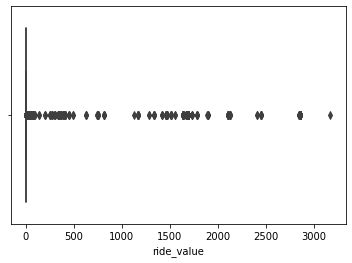

In [4]:
sns.boxplot(x='ride_value', data=df)
plt.show()

In [5]:
def plot_points(df, lat, lng, zoom):
    _map = folium.Map(location=[59.43961681353848, 24.75578956667034], zoom_start=zoom, add_google_map=True)
    for i in range(len(df)):
        tooltip = str(df['ride_value'].iloc[i])
        folium.Marker([df[lat].iloc[i], df[lng].iloc[i]], tooltip=tooltip).add_to(_map)
    return(_map)

In [6]:
# plot points to understand the characteristics of high ride value
thresh = 50
tmp = df[df.ride_value >= thresh]
print(round(tmp.shape[0]/df.shape[0]*100, 1), "%")

0.1 %


In [7]:
plot_points(tmp, 'start_lat', 'start_lng', 12)

In [9]:
plot_points(tmp, 'end_lat', 'end_lng', 2)

- **There are obvious bugs on some data as it should be impossible to drive from Talin to US (No road exist!!)**
- To simplify remove those data that are more than 600
- **Majority of the high value rides are abroad trip**

In [9]:
df = df[df.ride_value <= 600].reset_index(drop=True)

In [10]:
# calc vincenty distance
df['vincenty'] = [geodesic(ab, cd).km for ab, cd in zip(zip(df.start_lat, df.start_lng), zip(df.end_lat, df.end_lng))]

<AxesSubplot:xlabel='vincenty', ylabel='ride_value'>

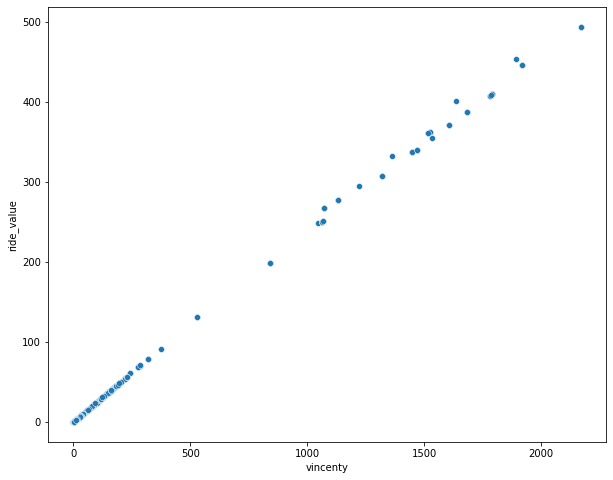

In [12]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='vincenty', y="ride_value", data=df)

- **Travel distance is seems the direct function of ride value**

## 1.2. Ride value and time <a class="anchor" id="eda-time"></a>

In [13]:
df['start_date'] = pd.DatetimeIndex(df['start_time']).strftime("%Y-%m-%d")
df['weekday'] = pd.DatetimeIndex(df['start_time']).strftime('%A')
df['hour'] = pd.DatetimeIndex(df['start_time']).strftime('%H')

In [14]:
df.groupby(['weekday'])['ride_value'].count().round().sort_values(ascending=False)

weekday
Saturday     106128
Friday        95456
Wednesday     94599
Tuesday       90566
Thursday      85565
Sunday        83566
Monday        71013
Name: ride_value, dtype: int64

In [15]:
df.groupby(['weekday'])['ride_value'].median().round(3).sort_values(ascending=False)

weekday
Friday       1.062
Thursday     1.062
Saturday     1.059
Tuesday      1.058
Wednesday    1.058
Sunday       1.057
Monday       1.049
Name: ride_value, dtype: float64

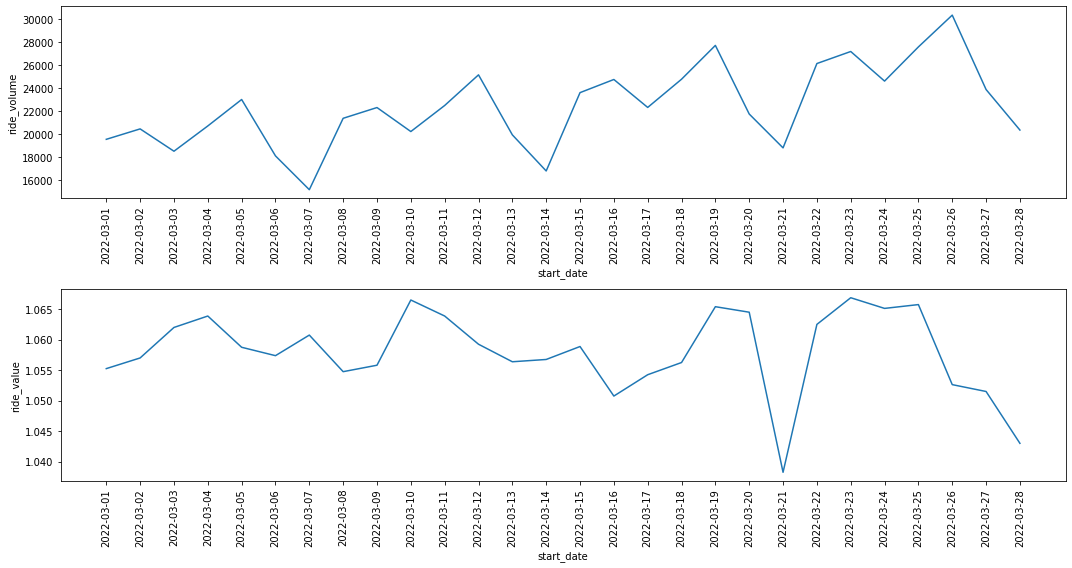

In [16]:
tmp2 = df.groupby(['start_date'])['ride_value'].count().reset_index().rename(columns={'ride_value':'ride_volume'})
tmp3 = df.groupby(['start_date'])['ride_value'].median().reset_index()

fig, ax = plt.subplots(2,1, figsize=(15,8))
sns.lineplot(x='start_date', y="ride_volume", data=tmp2, ax=ax[0])
sns.lineplot(x='start_date', y="ride_value", data=tmp3, ax=ax[1])
ax[0].tick_params(axis='x', rotation=90)
ax[1].tick_params(axis='x', rotation=90)
plt.tight_layout()

- Volume has clear cycle of weekday: increase on Tueaday and weekend (especially Saturday) are high volume, and drop on Monday and Wednesday
- However, cannot see clear pattern in ride value

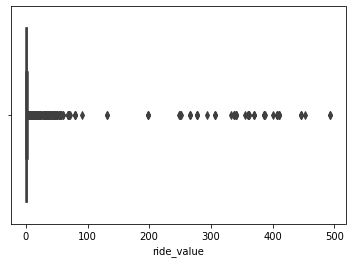

In [17]:
sns.boxplot(x='ride_value', data=df)
plt.show()

In [22]:
# take 95 percentile to look into high value rides
q95 = np.percentile(df['ride_value'], 95)
top = df[df.ride_value >= q95]

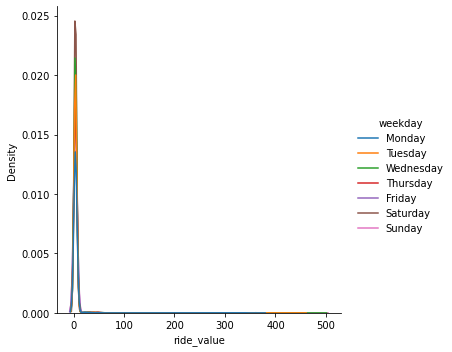

In [23]:
day_order = ['Monday','Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday']

sns.displot(x='ride_value', hue='weekday', hue_order=day_order, data=top, kind='kde')
plt.show()

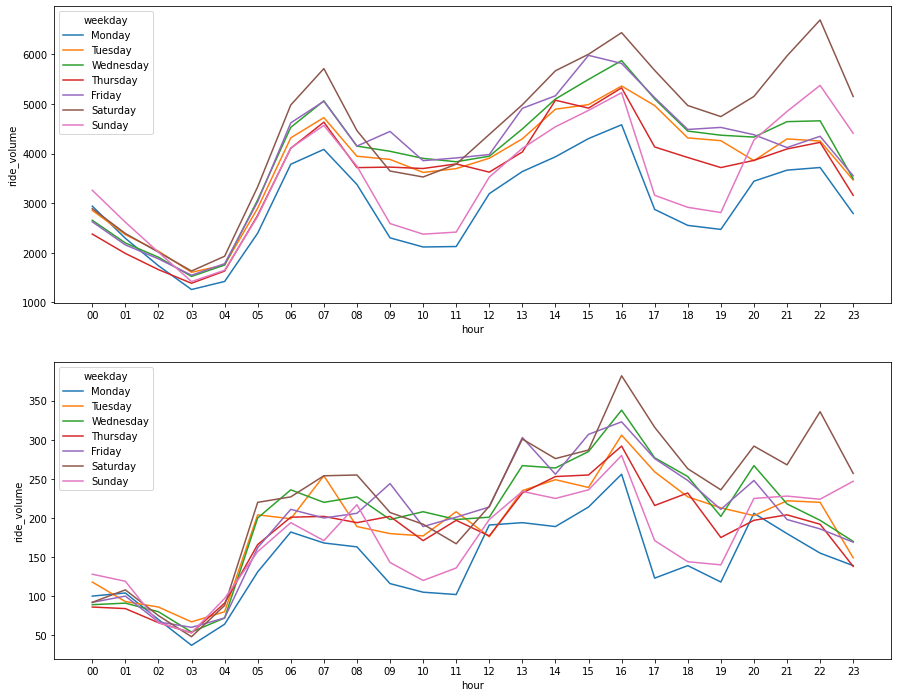

In [24]:
df_count = df.groupby(['weekday','hour'])['ride_value'].count().reset_index().rename(columns={'ride_value':'ride_volume'})
tmp_count_top = top.groupby(['weekday','hour'])['ride_value'].count().reset_index().rename(columns={'ride_value':'ride_volume'})

fig, ax = plt.subplots(2,1, figsize=(15, 12))
sns.lineplot(x='hour', y="ride_volume", hue="weekday", hue_order=day_order, data=df_count, ax=ax[0])
sns.lineplot(x='hour', y="ride_volume", hue="weekday", hue_order=day_order, data=tmp_count_top, ax=ax[1])
plt.show()

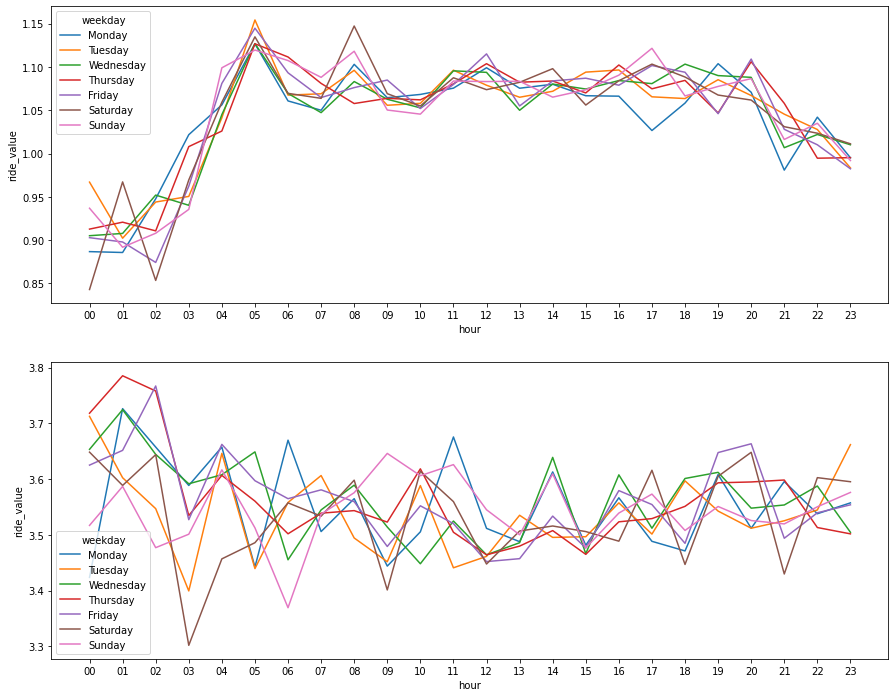

In [25]:
tmp_median = df.groupby(['weekday','hour'])['ride_value'].median().reset_index()
tmp_median_top = top.groupby(['weekday','hour'])['ride_value'].median().reset_index()

fig, ax = plt.subplots(2,1, figsize=(15, 12))
sns.lineplot(x='hour', y="ride_value", hue="weekday", hue_order=day_order, data=tmp_median, ax=ax[0])
sns.lineplot(x='hour', y="ride_value", hue="weekday", hue_order=day_order, data=tmp_median_top, ax=ax[1])
plt.show()

- There are peak trends on overall ride volume and value
- However, hard to see the hourly trend in high value rides occurance

# 2. Modeling <a class="anchor" id="modeling"></a>

## 2.1. Predict ride value and create heatmap <a class="anchor" id="model1"></a>

In [26]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
import xgboost
from scipy import stats
from scipy.special import inv_boxcox
from sklearn.multioutput import RegressorChain
from sklearn.metrics import mean_squared_error
import eli5
from eli5.sklearn import PermutationImportance

In [27]:
# Process time variables
df['minute'] = (pd.DatetimeIndex(df['start_time']).minute >= 30) 
df['minute'] = np.where(df['minute']==True, 1, 0.5) # simplyfy the minutes to 0.5 or 1
df['time_num'] = (df['hour'].astype('int') + df['minute']) / 24
df['time_str'] = df['hour'].astype('str')

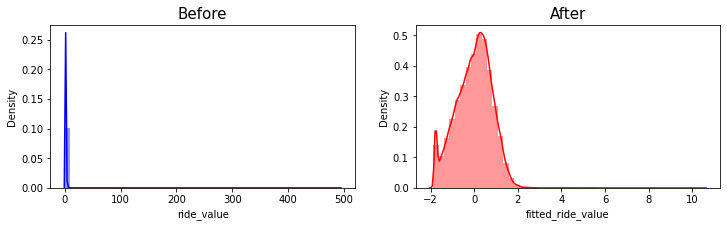

In [28]:
# fix skewness of target data
df['fitted_ride_value'], lmbda = stats.boxcox(df['ride_value'])
fig, ax = plt.subplots(1,2, figsize=(12,3))
sns.distplot(df['ride_value'], norm_hist=True, color = 'blue', ax=ax[0]).set_title("Before", fontsize=15)
sns.distplot(df['fitted_ride_value'], norm_hist=True, color = 'red', ax=ax[1]).set_title("After", fontsize=15)
plt.show()

In [57]:
train, test = train_test_split(df, test_size=0.15, random_state=42)

In [58]:
# Target encode
te1 = train.groupby('weekday', as_index=False)['ride_value'].median().rename(columns={'ride_value':'weekday_te'})
train = pd.merge(train, te1, how="left", on="weekday")
test = pd.merge(test, te1, how="left", on="weekday")

te2 = train.groupby('time_str', as_index=False)['ride_value'].median().rename(columns={'ride_value':'time_str_te'})
train = pd.merge(train, te2, how="left", on="time_str")
test = pd.merge(test, te2, how="left", on="time_str")

In [59]:
# Include only the variables which are available before the ride happens
X_train = train[['start_lat', 'start_lng', 'weekday_te', 'time_str_te']]
y_train = train[['fitted_ride_value']]

X_test = test[['start_lat', 'start_lng', 'weekday_te', 'time_str_te']]
y_test = test[['fitted_ride_value']]

### KNN

In [32]:
knn1 = KNeighborsRegressor(n_neighbors=20).fit(X_train, y_train)
pred_knn1 = knn1.predict(X_test)
pred_knn1_inv = inv_boxcox(pred_knn1, lmbda)
knn1_rmse = np.sqrt(mean_squared_error(y_test, pred_knn1_inv))
print("RMSE: %f" % (knn1_rmse))

RMSE: 1.310869


In [33]:
br1 = linear_model.BayesianRidge().fit(X_train, y_train)
pred_br1 = br1.predict(X_test)
pred_br1_inv = inv_boxcox(pred_br1, lmbda)
br1_rmse = np.sqrt(mean_squared_error(y_test, pred_br1_inv))
print("RMSE: %f" % (br1_rmse))

RMSE: 1.294057


In [34]:
perm_br1 = PermutationImportance(br1).fit(X_train, y_train)
eli5.show_weights(perm_br1, feature_names=X_train.columns.tolist())

Weight,Feature
0.0071 ± 0.0005,time_str_te
0.0043 ± 0.0002,start_lat
0.0023 ± 0.0001,start_lng
-0.0000 ± 0.0000,weekday_te


### Random Forest

In [113]:
# To prevent overfitting early stop when test performs worse than previous best model at certain threshold

def earlystop(model, X_train, y_train, n_estimators=100, step=10, thresh=0.001):
    obs = []
    rmse_best = float('inf')
    for iter in range(0, n_estimators, step):
        model.fit(X_train, y_train)
        y_train_predicted = model.predict(X_train)
        y_test_predicted = model.predict(X_test)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predicted))
        rmse_best = min(rmse_best, rmse_test) 
        if rmse_best==rmse_test or rmse_test-rmse_best < thresh:
            additional_estinators = iter
            obs.append({'additional_estinators':additional_estinators, 'rmse_train':rmse_train, 'rmse_test':rmse_test})
            print(additional_estinators, rmse_train, rmse_test)
            model.n_estimators += 1
        else:
            break
    return model, pd.DataFrame(obs)

In [140]:
rf1 = RandomForestRegressor(max_depth=3, n_estimators=1)
rf1, obs = earlystop(rf1, X_train, y_train, step=10, thresh=0.00001)

0 0.7343104595754789 0.736838171161892
10 0.7341323721811138 0.736688982339074
20 0.7340850323869199 0.7366988995603526
30 0.7340425179434397 0.7366612864293043
40 0.73405152376368 0.7366211165112256
50 0.7340193361906697 0.7365891864971857
60 0.7339301368642788 0.7364860534302177
70 0.7338615860659687 0.7363829734888493


In [141]:
def plot_learning_curve(obs):
    fig, ax = plt.subplots(figsize=(8,5))
    x_axis = range(0, len(obs))
    ax.plot(x_axis, obs['rmse_train'], label='Train')
    ax.plot(x_axis, obs['rmse_test'], label='Test')
    ax.legend()
    plt.xlabel('Number of estimators in the unit of step',fontsize=15)
    plt.ylabel('RMSE',fontsize=15)
    return plt.show()

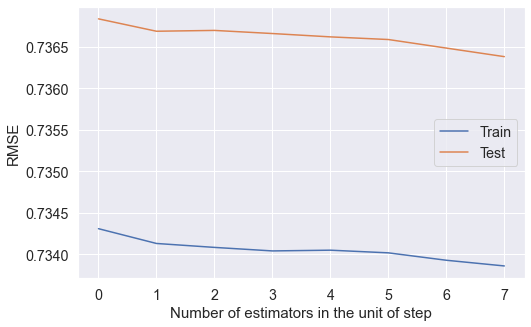

In [142]:
plot_learning_curve(obs)

In [125]:
pred_rf1 = rf1.predict(X_test)
pred_rf1_inv = inv_boxcox(pred_rf1, lmbda)
rf1_rmse = np.sqrt(mean_squared_error(y_test, pred_rf1_inv))
print("RMSE: %f" %(rf1_rmse))

RMSE: 1.294171


In [64]:
perm_rf1 = PermutationImportance(rf1).fit(X_train, y_train)
eli5.show_weights(perm_rf1, feature_names=X_train.columns.tolist())

Weight,Feature
0.2858 ± 0.0014,start_lng
0.0565 ± 0.0006,start_lat
0 ± 0.0000,time_str_te
0 ± 0.0000,weekday_te


### XGBoost

In [146]:
xgb1 = xgboost.XGBRegressor(max_depth=4, n_estimators=1, eta=0.1, reg_lambda=2, eval_metric=["rmse"])
xgb1, obs = earlystop(xgb1, X_train, y_train, step=5, thresh=0)

0 0.9233412151153094 0.9282020755413006
5 0.8893237797994992 0.8940240530306044
10 0.8605718108262633 0.8651105030051416
15 0.8366618143844001 0.8410336830889864
20 0.8163152230771628 0.8205330842334232
25 0.7995325748308689 0.8035896780698366
30 0.7854439175248827 0.7893643627978554
35 0.7737725805636596 0.7775574939106629
40 0.7643086405184867 0.768004927563322
45 0.7562575036208092 0.7598304874851453
50 0.7496031786824648 0.7530576411137531
55 0.7442283910226708 0.7475923473969066
60 0.7396818018659006 0.74295962978027
65 0.7359269734601076 0.7391669970684114
70 0.7328987268953324 0.7360607800964518
75 0.7303069606180652 0.7334120683229417
80 0.7281652125513632 0.7312120353791562
85 0.7264293617244582 0.7294215278478834
90 0.724920494060139 0.727885277313421
95 0.7236906888628131 0.7266142212353145


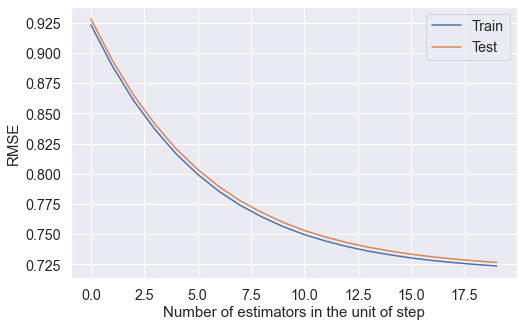

In [147]:
plot_learning_curve(obs)

In [148]:
pred_xgb1 = xgb1.predict(X_test)
pred_xgb1_inv = inv_boxcox(pred_xgb1, lmbda)
xgb1_rmse = np.sqrt(mean_squared_error(y_test, pred_xgb1_inv))
print("RMSE: %f" %(xgb1_rmse))

RMSE: 1.330317


In [67]:
perm_xgb1 = PermutationImportance(xgb1).fit(X_train, y_train)
eli5.show_weights(perm_xgb1, feature_names=X_train.columns.tolist())

Weight,Feature
0.2421 ± 0.0010,start_lng
0.1027 ± 0.0009,start_lat
0.0006 ± 0.0000,time_str_te
0.0000 ± 0.0000,weekday_te


### Stack linear, unsupervised, and boosting

In [135]:
estimators = [('br1', br1), ('knn1', knn1)]
stack = StackingRegressor(estimators=estimators, final_estimator=xgb1).fit(X_train, y_train)
pred_stack = stack.predict(X_test)
pred_stack_inv = inv_boxcox(pred_stack, lmbda)
stack_rmse = np.sqrt(mean_squared_error(y_test, pred_stack_inv))
print("RMSE: %f" %(stack_rmse))

RMSE: 1.329890


In [69]:
perm_stack = PermutationImportance(stack).fit(X_train, y_train)
eli5.show_weights(perm_stack, feature_names=X_train.columns.tolist())

Weight,Feature
0.3270 ± 0.0005,start_lng
0.2040 ± 0.0024,start_lat
0.0940 ± 0.0009,time_str_te
0.0320 ± 0.0007,weekday_te


In [143]:
result1 = {'Model': ['KNN','Bayesian Ridge','Random Forest','XGBoost', 'Stacking'],
          'RMSE' : [knn1_rmse, br1_rmse, rf1_rmse, xgb1_rmse, stack_rmse]}
result1_df = pd.DataFrame(result1).sort_values('RMSE').sort_values(by='RMSE').reset_index(drop=True)
result1_df

,Model,RMSE
0,Bayesian Ridge,1.294057
1,Random Forest,1.294171
2,KNN,1.310869
3,Stacking,1.329890
4,XGBoost,1.330317


- Model is still really bad for production, due to the extreme values
- I will try HMM model and also separate prediction for extremely high values with anormality detection for further work

In [43]:
pred_df = pd.DataFrame(pred_knn1, columns=['pred_ride_value'])
y_testt = y_test.reset_index()
pred_df_ = pd.concat([pred_df, y_testt], axis=1).set_index('index')
pred_merged = pd.merge(pred_df_, df, left_index=True, right_index=True)
pred_merged['start_geo'] = [Point(ab) for ab in zip(pred_merged.start_lng, pred_merged.start_lat)]
gdf = gpd.GeoDataFrame(pred_merged, crs=4326, geometry='start_geo')

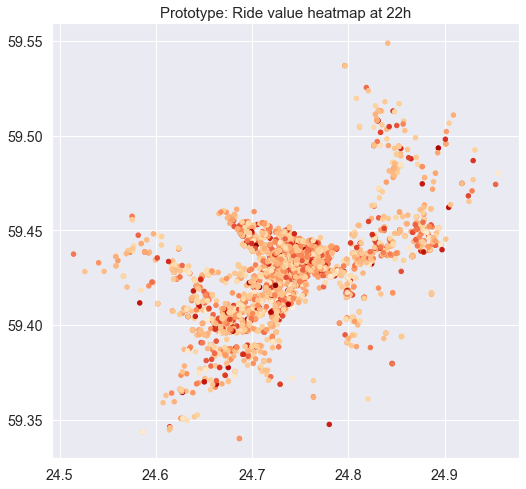

In [44]:
gdf[gdf.time_str=='22'].plot(column='pred_ride_value', marker='o', cmap='OrRd', markersize=20, figsize=(12,8)).set_title('Prototype: Ride value heatmap at 22h', fontsize=15)
plt.show()

## 2.2 Predict starting geometry  (out of scope)<a class="anchor" id="model2"></a>

This case, we can suggest the location based on certain threshold of ride value. <br>
This can be useful if driver wish to drive only certain travel distance (within X km), due to the other constrains and want to find the closest start point. <br>

In [167]:
# predict the demand location (Multioutput regression) based on the week, hour, travel distance and ride value
# ride value can be calculated based on the given distance
X_train = train[['ride_value', 'weekday_te', 'time_num', 'vincenty']]
y_train = train[['start_lat', 'start_lng']]

X_test = test[['ride_value', 'weekday_te', 'time_num', 'vincenty']]
y_test = test[['start_lat', 'start_lng']]

### KNN

In [168]:
knn2 = KNeighborsRegressor().fit(X_train, y_train)
pred_knn2 = knn2.predict(X_test)
knn2_rmse = np.sqrt(mean_squared_error(y_test, pred_knn2))
print("RMSE: %f" % (knn_rmse))

RMSE: 0.038237


### Random Forest

In [171]:
rf2 = RandomForestRegressor(n_estimators=1)
rf2, obs = earlystop(rf2, X_train, y_train, step=20, thresh=0.0001)

0 0.027638263360512543 0.04560853156205289
20 0.02098316257046805 0.03821587320469975
40 0.018323462939252168 0.03540111282743069
60 0.016804491143935774 0.034251177162340725
80 0.015800386367074974 0.03359951800613245


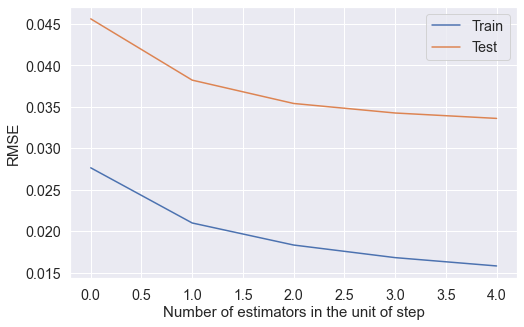

In [172]:
plot_learning_curve(obs)

In [173]:
pred_rf2 = rf2.predict(X_test)
rf2_rmse = np.sqrt(mean_squared_error(y_test, pred_rf2))
print("RMSE: %f" %(rf2_rmse))

RMSE: 0.033600


In [174]:
perm_rf2 = PermutationImportance(rf2).fit(X_train, y_train)
eli5.show_weights(perm_rf2, feature_names=X_train.columns.tolist())

Weight,Feature
1.1816 ± 0.0016,vincenty
1.1746 ± 0.0025,ride_value
0.9198 ± 0.0032,time_num
0.1305 ± 0.0004,weekday_te


In [175]:
# Calculate the actual error of distance in km
pred_df = pd.DataFrame(pred_rf2, columns=['pred_start_lat', 'pred_start_lng'])
y_testt = y_test.reset_index()
result_df = pd.concat([pred_df, y_testt], axis=1)
result_df['residual_distance'] = [geodesic(ab, cd).km for ab, cd in zip(zip(result_df.pred_start_lat, result_df.pred_start_lng), zip(result_df.start_lat, result_df.start_lng))]
print("Mean error %f km" %(result_df['residual_distance'].mean().round(2)))

Mean error 2.090000 km


### XGBoost

In [176]:
xgb2 = xgboost.XGBRegressor(max_depth=5, n_estimators=150, eta=0.1, reg_lambda=1, reg_alpha=2, eval_metric=["rmse"])
rcxgb = RegressorChain(xgb2).fit(X_train, y_train)
pred_rcxgb = rcxgb.predict(X_test)
rcxgb_rmse = np.sqrt(mean_squared_error(y_test, pred_rcxgb))
print("RMSE: %f" %(rcxgb_rmse))

RMSE: 0.043353


In [177]:
perm_rcxgb = PermutationImportance(rcxgb).fit(X_train, y_train)
eli5.show_weights(perm_rcxgb, feature_names=X_train.columns.tolist())

Weight,Feature
0.2888 ± 0.0006,vincenty
0.2641 ± 0.0013,ride_value
0.0094 ± 0.0006,time_num
0.0001 ± 0.0000,weekday_te


### Overall evaluation

,Model,RMSE
0,Random Forest,0.033600
1,KNN,0.038237
2,XGBoost,0.043353


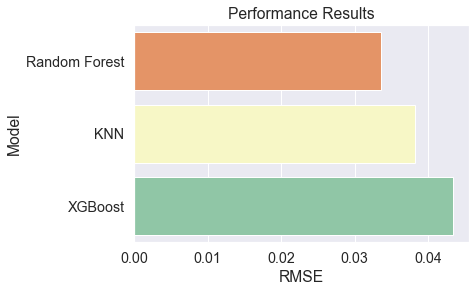

In [178]:
result = {'Model': ['KNN','Random Forest','XGBoost'],
          'RMSE' : [knn2_rmse, rf2_rmse, rcxgb_rmse]}
result_df = pd.DataFrame(result).sort_values('RMSE').sort_values(by='RMSE').reset_index(drop=True)
sns.barplot(data=result_df, y='Model', x='RMSE', palette="Spectral")
plt.title('Performance Results')
result_df

- The best model predict with **mean error of 2km**, which can be viable to deploy in the production
- For further work I would implement below solution with HMM: <br>
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0207063

# 3. Thoughts: Deployment and A/B test ideas  <a class="anchor" id="thoughts"></a>

#### Before deployment:
- Would try Time series Hidden Markov Model to consider the time series better (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0207063)
- Would try to predict all the international ride with anormality detection as they are very rare event (<0.1%)
- Would further look into the correlated variables especially with the international ride - user attribute etc 
- Predict the points which were not in training dataset to complete the whole map with start latitude and longitude and timestamp

#### What: Heatmap of the predicted ride value at given time
- Show heatmap of the predicted ride value at given time
- Model should be tuned and re-trained wih incoming data (timestamp, start latitude and longitude, ride value) at certain interval (5 days, everyday etc)
- Version the models, thier performances, and trained datasets to monitor performance and bugs

<img src="heatmap.png" width="400">

#### Where: Test at Talin, Estonia 
- Both iOS and Android app

#### Why: Increase revenue by conversion rate of rides especiall for high value rides 
Possible metrics to test
- Response rate of the driver to the heatmap based on the model
- Reduce in conversion rate in high value ride
- Revenue per drive uplift
- Shortening waiting time

#### Who: Bucketing idea for treatment group
1. Randomized experimentation
2. Quasi-experimentation <br>
As sugggesting to go to high ride value area to random drivers in certain time can create competition among drivers, we can test subgroups and compare the result to randomized test:
- Select drivers who are in demand area
- Select drivers who are in high supply area (where demand < supply)
- Select drivers who are earning less than average
- Select drivers who are willing to drive long 